## 工具

# Add tools
## 1. Install the search engine
`pip install -U langchain-tavily`
## 2. Configure your environment¶

In [1]:
import os

os.environ["TAVILY_API_KEY"] = "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"

## 3. Define the tool

In [2]:
from langchain_tavily import TavilySearch

tool = TavilySearch(max_results=2)
tools = [tool]
tool.invoke("2025年08月26日，中国A股上证指数？")

{'query': '2025年08月26日，中国A股上证指数？',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'http://www.stcn.com/article/detail/3266888.html',
   'title': '权重股走强A股成交额超3万亿元 - 证券时报',
   'content': '权重股走强 A股成交额超3万亿元 来源：中国证券报作者：吴玉华2025-08-26 07:09 8月25日，A股市场主要指数普遍上涨。成交额放量至3.18万亿元，创历史第二高，为连续9个交易日超2万亿元。通信板块领涨市场，行业板块全线上涨，整个A股市场超3300只股票上涨，逾90只股票涨停。 分析人士认为，当前市场情况下，赛道轮动仍是最显著的行情特征，市场有望围绕AI产业链、“反内卷”、非银金融等板块轮动。 **主要指数普遍上涨** 8月25日，A股市场主要指数均上涨。截至收盘，上证指数、深证成指、创业板指、科创50指数、北证50指数分别上涨1.51%、2.26%、3.00%、3.20%、0.23%。 权重股走强，大盘股集中的上证50指数、沪深300指数分别上涨2.09%、2.08%，小微股集中的中证1000指数、中证2000指数、万得微盘股指数分别上涨1.56%、1.17%、0.27%，大盘股表现更为强势。 部分大盘股走强带动指数上行，从对指数贡献度来看，中际旭创、新易盛、胜宏科技、宁德时代、阳光电源对创业板指贡献点数居前，合计为50.94点，占创业板指上涨点数的逾六成。寒武纪-U、海光信息、澜起科技、芯原股份、大全能源对科创50指数贡献点数居前，合计为38.97点，占科创50指数上涨点数的逾九成。 场内资金成交活跃，当日A股市场成交额为3.18万亿元，创历史第二高，仅次于2024年10月8日的3.48万亿元。其中沪市成交额为13609.04亿元，深市成交额为17802.33亿元。 从盘面上看，钨矿、光模块、稀土永磁、卫星互联网等板块走强，电动车、显示面板等板块有所调整。申万一级行业均上涨，通信、有色金属、房地产行业涨幅居前，分别上涨4.85%、4.63%、3.32%。 近期A股成交总体呈放量趋势，自8月13日以来，A股成交额已

## 4. Define the graph

In [3]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
        # model="Qwen/Qwen2.5-72B-Instruct",
        model="Qwen/Qwen3-8B",
        # 硅基流动
        api_key="sk-jvjyawqpodlkxlywatvemcdykkrbvthhjyjyapyvtnifwlbl",
        base_url="https://api.siliconflow.cn/v1/",
        # # modelscope 
        # base_url="https://api-inference.modelscope.cn/v1/",
        # api_key="ms-e2666046-2f3b-4c76-bcc0-e21f8ebf9ea1",
    )

In [4]:
# 将其合并到 StateGraph 中：
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

# Modification: tell the LLM which tools it can call
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

## 5. Create a function to run the tools
现在，创建一个函数，以便在调用工具时运行它们。  
通过将工具添加到名为 BasicToolNode 的新节点来实现这一点，该节点检查状态中的最新消息，如果消息包含 tool_calls，则调用工具。  
它依赖于 LLM 的 tool_calling 支持，该支持可在 Anthropic，OpenAI，Google Gemini 和许多其他 LLM 提供商中使用。

In [5]:
import json
from langchain_core.messages import ToolMessage


class BasicToolNode:
    """A node that runs the tools requested in the last AIMessage."""

    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs: dict):
        # 从输入字典 inputs 中获取键为 "messages" 的值，如果该键不存在，则默认返回空列表 []。
        # 使用海象运算符 := 将获取的值赋值给变量 messages，同时检查该值是否为非空。
        # 如果 messages 非空，则条件成立，执行后续代码。
        if messages := inputs.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("No message found in input")
        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            outputs.append(
                ToolMessage(
                    content=json.dumps(tool_result),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )
        return {"messages": outputs}

tool_node = BasicToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

## 6. Define the conditional_edges
1. 添加工具节点后，现在可以定义 conditional_edges。
2. 边将控制流从一个节点路由到下一个节点。 条件边从单个节点开始，通常包含“if”语句，以根据当前图状态路由到不同的节点。这些函数接收当前图状态 ，并返回一个字符串或字符串列表，指明接下来要调用的节点。
3. 接下来，定义一个名为 route_tools 的路由器函数，用于检查聊天机器人输出中的 tool_calls。通过调用 add_conditional_edges 向图提供此函数，这会告诉图，每当聊天机器人节点完成时，检查此函数以查看下一步要去哪里。
4. 如果存在工具调用，则条件将路由到工具 ，如果不存在 ，则结束 。因为条件可以返回 END，所以这次不需要显式设置 finish_point。

In [6]:
def route_tools(
    state: State,
):
    """
    Use in the conditional_edge to route to the ToolNode if the last message
    has tool calls. Otherwise, route to the end.
    """
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return END


# The `tools_condition` function returns "tools" if the chatbot asks to use a tool, and "END" if
# it is fine directly responding. This conditional routing defines the main agent loop.
graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    # The following dictionary lets you tell the graph to interpret the condition's outputs as a specific node
    # It defaults to the identity function, but if you
    # want to use a node named something else apart from "tools",
    # You can update the value of the dictionary to something else
    # e.g., "tools": "my_tools"
    {"tools": "tools", END: END},
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

## 7. Visualize the graph (optional)

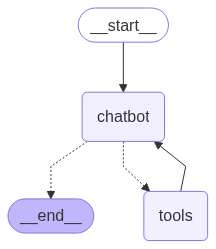

In [7]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

## 8. Ask the bot questions

In [9]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)
    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: 


Assistant: {"query": "2025年08月26日 中国A股 上证指数", "follow_up_questions": null, "answer": null, "images": [], "results": [{"url": "https://hk.finance.yahoo.com/quote/SPXW250826C06475000/", "title": "I:SPX Aug 2025 Weekly 6475.000 (SPXW250826C06475000) 股價", "content": "-73.58% · 前收市價 15.73 · 開市 12.33 · 買入價 12.20 · 賣出價 12.50 · 拍板 6,475.00 · 到期日 2025-08-26 · 今日波幅 11.40 - 12.33 · 合同範圍 --", "score": 0.88564163, "raw_content": null}, {"url": "https://cn.wsj.com/articles/%E9%9A%94%E5%A4%9C%E5%B8%82%E5%9C%BA%E5%9B%9E%E9%A1%BE-%E5%9C%B0%E7%BC%98%E6%94%BF%E6%B2%BB%E9%A3%8E%E9%99%A9%E4%B8%8A%E5%8D%87%E6%8E%A8%E9%AB%98%E5%8E%9F%E6%B2%B9%E6%9C%9F%E8%B4%A7-ab0357d7", "title": "隔夜市场回顾：地缘政治风险上升推高原油期货 - 华尔街日报", "content": "2025年8月26日07:20 CST. 图片来源：ALEXANDER MANZYUK/REUTERS. 股票市场. 道琼斯 ... 中国股市上涨，上证综指创十年新高. 中国股市上涨，上证综指创十年新高 · 习近平", "score": 0.7476348, "raw_content": null}], "response_time": 1.66, "request_id": "4ebe67c6-2d8c-4225-985d-4471593888a7"}
Assistant: 

根据目前可获取的信息，2025年8月26日并非实际已发生的时间点

## 9. Use prebuilts
为了便于使用，请调整您的代码，将以下内容替换为 LangGraph 预构建的组件。这些都内置了类似并行 API 执行的功能。  
- BasicToolNode 替换为预构建的 ToolNode
- route_tools 替换为预构建的 tools_condition

In [8]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.messages import BaseMessage
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

tool = TavilySearch(max_results=2)
tools = [tool]
llm_with_tools = llm.bind_tools(tools)

def chatbot(state: State):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

graph_builder.add_node("chatbot", chatbot)

tool_node = ToolNode(tools=[tool])
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)
# Any time a tool is called, we return to the chatbot to decide the next step
graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()